# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

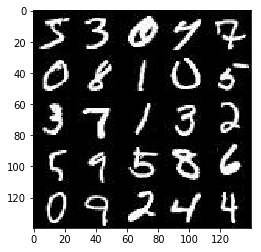

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

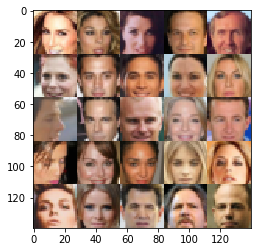

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #x1 = tf.nn.relu(x1)
        #print('discriminator x1:', x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.01 * x2, x2)
        #x2 = tf.nn.relu(x2)
        #print('discriminator x2:', x2)
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.01 * x3, x3)
        #x3 = tf.nn.relu(x3)
        #print('discriminator x3:', x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        #print('discriminator flat:', flat)
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    if is_train:
        reuse = False
    else:
        reuse = True

    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1,(-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01 * x1, x1)
        #x1 = tf.nn.relu(x1)
        #print('generator x1:', x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=3, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(0.01 * x2, x2)
        #x2 = tf.nn.relu(x2)
        #print('generator x2:', x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(0.01 * x3, x3)
        #x3 = tf.nn.relu(x3)
        #print('generator x3:', x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print('generator logits:', logits)

        out = 0.5*tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #ops_t = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    with tf.control_dependencies(ops):        

        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    sampless = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(sampless, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
from os.path import isdir
if not isdir('checkpoints'):
    !mkdir checkpoints

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    from time import time
    

    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
        
    #samples, losses = [], []
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            t0=time()
            for batch_images in get_batches(batch_size):
                # TODO: Train Model               
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate:learningRate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate:learningRate})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...{}".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    #samples.append(samples)
            print('The residual time nearly to be:  {:.0f}  minutes.'.format((epoch_count-epoch_i-1)*(time()-t0)/60))
                    
                #saver.save(sess, './checkpoints/generator.ckpt')
        saver.save(sess, './checkpoints/generator.ckpt')
        
    #import pickle as pkl
    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    #return losses, samples  

    return 
        

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2...50 Discriminator Loss: 0.3389... Generator Loss: 5.3330
Epoch 1/2...100 Discriminator Loss: 0.5402... Generator Loss: 6.0374
Epoch 1/2...150 Discriminator Loss: 0.3447... Generator Loss: 5.5369
Epoch 1/2...200 Discriminator Loss: 0.3351... Generator Loss: 7.4591
Epoch 1/2...250 Discriminator Loss: 0.3309... Generator Loss: 8.1761
Epoch 1/2...300 Discriminator Loss: 0.3332... Generator Loss: 6.2269
Epoch 1/2...350 Discriminator Loss: 0.3295... Generator Loss: 7.4106
Epoch 1/2...400 Discriminator Loss: 0.3302... Generator Loss: 7.7761
Epoch 1/2...450 Discriminator Loss: 0.3300... Generator Loss: 6.8423
Epoch 1/2...500 Discriminator Loss: 0.3294... Generator Loss: 7.8600


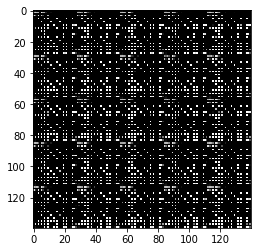

Epoch 1/2...550 Discriminator Loss: 0.3288... Generator Loss: 7.6113
Epoch 1/2...600 Discriminator Loss: 0.3298... Generator Loss: 6.6453
Epoch 1/2...650 Discriminator Loss: 0.3279... Generator Loss: 7.8885
Epoch 1/2...700 Discriminator Loss: 0.3274... Generator Loss: 8.2086
Epoch 1/2...750 Discriminator Loss: 0.3281... Generator Loss: 8.1701
Epoch 1/2...800 Discriminator Loss: 0.3264... Generator Loss: 8.8138
Epoch 1/2...850 Discriminator Loss: 0.3260... Generator Loss: 9.1411
Epoch 1/2...900 Discriminator Loss: 0.3294... Generator Loss: 7.0351
Epoch 1/2...950 Discriminator Loss: 0.5318... Generator Loss: 2.2840
Epoch 1/2...1000 Discriminator Loss: 0.4495... Generator Loss: 3.9490


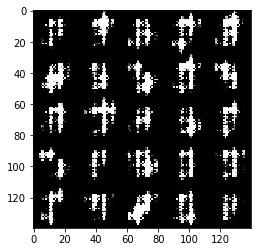

Epoch 1/2...1050 Discriminator Loss: 1.0597... Generator Loss: 3.2622
Epoch 1/2...1100 Discriminator Loss: 0.8573... Generator Loss: 1.5735
Epoch 1/2...1150 Discriminator Loss: 0.7016... Generator Loss: 1.6600
Epoch 1/2...1200 Discriminator Loss: 0.8623... Generator Loss: 1.6117
Epoch 1/2...1250 Discriminator Loss: 0.7188... Generator Loss: 2.0089
Epoch 1/2...1300 Discriminator Loss: 1.1180... Generator Loss: 1.6316
Epoch 1/2...1350 Discriminator Loss: 1.0953... Generator Loss: 0.8405
Epoch 1/2...1400 Discriminator Loss: 0.8792... Generator Loss: 1.5051
Epoch 1/2...1450 Discriminator Loss: 0.9927... Generator Loss: 1.6527
Epoch 1/2...1500 Discriminator Loss: 0.9506... Generator Loss: 1.3670


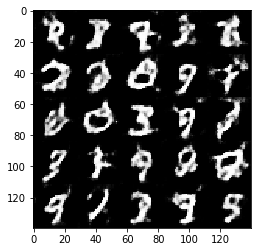

Epoch 1/2...1550 Discriminator Loss: 0.9827... Generator Loss: 0.9364
Epoch 1/2...1600 Discriminator Loss: 1.0275... Generator Loss: 1.1680
Epoch 1/2...1650 Discriminator Loss: 0.8930... Generator Loss: 1.3944
Epoch 1/2...1700 Discriminator Loss: 0.9957... Generator Loss: 1.0734
Epoch 1/2...1750 Discriminator Loss: 0.9990... Generator Loss: 1.0380
Epoch 1/2...1800 Discriminator Loss: 0.8868... Generator Loss: 1.3957
Epoch 1/2...1850 Discriminator Loss: 1.1345... Generator Loss: 0.9370
The residual time nearly to be:  2  minutes.
Epoch 2/2...1900 Discriminator Loss: 0.9352... Generator Loss: 1.4005
Epoch 2/2...1950 Discriminator Loss: 0.9077... Generator Loss: 1.1666
Epoch 2/2...2000 Discriminator Loss: 1.0499... Generator Loss: 1.0114


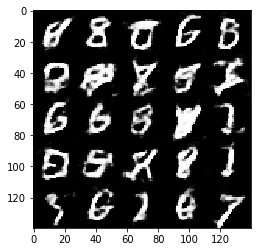

Epoch 2/2...2050 Discriminator Loss: 0.8801... Generator Loss: 1.5189
Epoch 2/2...2100 Discriminator Loss: 0.9551... Generator Loss: 1.1257
Epoch 2/2...2150 Discriminator Loss: 1.2982... Generator Loss: 0.6585
Epoch 2/2...2200 Discriminator Loss: 1.0025... Generator Loss: 0.9451
Epoch 2/2...2250 Discriminator Loss: 1.0884... Generator Loss: 0.8531
Epoch 2/2...2300 Discriminator Loss: 0.9699... Generator Loss: 1.4165
Epoch 2/2...2350 Discriminator Loss: 0.8843... Generator Loss: 1.1832
Epoch 2/2...2400 Discriminator Loss: 1.0728... Generator Loss: 0.8930
Epoch 2/2...2450 Discriminator Loss: 1.1861... Generator Loss: 0.6945
Epoch 2/2...2500 Discriminator Loss: 1.0657... Generator Loss: 0.9033


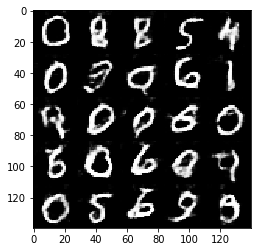

Epoch 2/2...2550 Discriminator Loss: 1.0224... Generator Loss: 0.8713
Epoch 2/2...2600 Discriminator Loss: 1.0030... Generator Loss: 1.2459
Epoch 2/2...2650 Discriminator Loss: 1.1897... Generator Loss: 0.8949
Epoch 2/2...2700 Discriminator Loss: 1.3195... Generator Loss: 0.8452
Epoch 2/2...2750 Discriminator Loss: 1.1275... Generator Loss: 1.6049
Epoch 2/2...2800 Discriminator Loss: 0.9714... Generator Loss: 1.3515
Epoch 2/2...2850 Discriminator Loss: 0.9759... Generator Loss: 1.0301
Epoch 2/2...2900 Discriminator Loss: 0.9918... Generator Loss: 1.1971
Epoch 2/2...2950 Discriminator Loss: 1.0676... Generator Loss: 1.2012
Epoch 2/2...3000 Discriminator Loss: 1.0673... Generator Loss: 1.1693


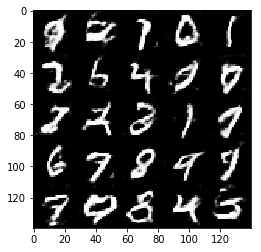

Epoch 2/2...3050 Discriminator Loss: 1.1181... Generator Loss: 0.9418
Epoch 2/2...3100 Discriminator Loss: 1.2090... Generator Loss: 0.6999
Epoch 2/2...3150 Discriminator Loss: 1.2829... Generator Loss: 0.6593
Epoch 2/2...3200 Discriminator Loss: 1.1020... Generator Loss: 1.1839
Epoch 2/2...3250 Discriminator Loss: 1.0621... Generator Loss: 0.8590
Epoch 2/2...3300 Discriminator Loss: 1.0291... Generator Loss: 1.0769
Epoch 2/2...3350 Discriminator Loss: 1.1815... Generator Loss: 1.2063
Epoch 2/2...3400 Discriminator Loss: 1.3923... Generator Loss: 0.5364
Epoch 2/2...3450 Discriminator Loss: 1.1230... Generator Loss: 0.8134
Epoch 2/2...3500 Discriminator Loss: 1.0878... Generator Loss: 1.2472


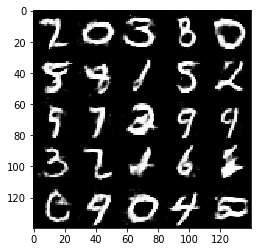

Epoch 2/2...3550 Discriminator Loss: 1.1228... Generator Loss: 0.9834
Epoch 2/2...3600 Discriminator Loss: 1.3324... Generator Loss: 1.0350
Epoch 2/2...3650 Discriminator Loss: 1.0147... Generator Loss: 1.0813
Epoch 2/2...3700 Discriminator Loss: 1.2155... Generator Loss: 0.9707
Epoch 2/2...3750 Discriminator Loss: 1.0221... Generator Loss: 1.1264
The residual time nearly to be:  0  minutes.


In [13]:
batch_size = 32
z_dim = 100
learningRate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learningRate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1...50 Discriminator Loss: 0.4176... Generator Loss: 3.7365
Epoch 1/1...100 Discriminator Loss: 0.3628... Generator Loss: 5.0568
Epoch 1/1...150 Discriminator Loss: 0.3504... Generator Loss: 7.8277
Epoch 1/1...200 Discriminator Loss: 0.3378... Generator Loss: 7.7362
Epoch 1/1...250 Discriminator Loss: 0.3330... Generator Loss: 6.5202
Epoch 1/1...300 Discriminator Loss: 0.3368... Generator Loss: 4.9765
Epoch 1/1...350 Discriminator Loss: 0.3439... Generator Loss: 5.4928
Epoch 1/1...400 Discriminator Loss: 0.3393... Generator Loss: 5.9309
Epoch 1/1...450 Discriminator Loss: 0.3442... Generator Loss: 6.1332
Epoch 1/1...500 Discriminator Loss: 0.3603... Generator Loss: 4.5625


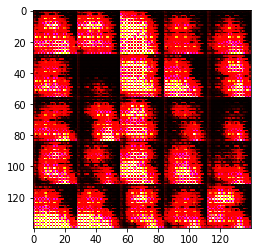

Epoch 1/1...550 Discriminator Loss: 0.3365... Generator Loss: 6.2337
Epoch 1/1...600 Discriminator Loss: 0.3598... Generator Loss: 6.5392
Epoch 1/1...650 Discriminator Loss: 0.3438... Generator Loss: 6.1401
Epoch 1/1...700 Discriminator Loss: 0.3365... Generator Loss: 7.4525
Epoch 1/1...750 Discriminator Loss: 0.3356... Generator Loss: 7.0486
Epoch 1/1...800 Discriminator Loss: 0.3322... Generator Loss: 7.5528
Epoch 1/1...850 Discriminator Loss: 0.4574... Generator Loss: 3.7521
Epoch 1/1...900 Discriminator Loss: 0.3696... Generator Loss: 3.9801
Epoch 1/1...950 Discriminator Loss: 0.3756... Generator Loss: 4.2265
Epoch 1/1...1000 Discriminator Loss: 0.3458... Generator Loss: 7.0522


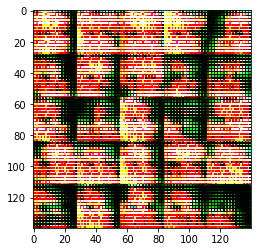

Epoch 1/1...1050 Discriminator Loss: 0.3295... Generator Loss: 6.6661
Epoch 1/1...1100 Discriminator Loss: 0.3401... Generator Loss: 6.2686
Epoch 1/1...1150 Discriminator Loss: 0.3373... Generator Loss: 6.2027
Epoch 1/1...1200 Discriminator Loss: 0.3381... Generator Loss: 6.7617
Epoch 1/1...1250 Discriminator Loss: 0.3307... Generator Loss: 7.4769
Epoch 1/1...1300 Discriminator Loss: 0.3303... Generator Loss: 6.5347
Epoch 1/1...1350 Discriminator Loss: 0.3335... Generator Loss: 7.1822
Epoch 1/1...1400 Discriminator Loss: 0.3262... Generator Loss: 7.9101
Epoch 1/1...1450 Discriminator Loss: 0.3331... Generator Loss: 8.1068
Epoch 1/1...1500 Discriminator Loss: 0.3288... Generator Loss: 8.2418


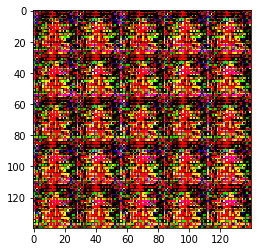

Epoch 1/1...1550 Discriminator Loss: 0.3288... Generator Loss: 8.7185
Epoch 1/1...1600 Discriminator Loss: 0.3273... Generator Loss: 8.3827
Epoch 1/1...1650 Discriminator Loss: 0.3769... Generator Loss: 4.5059
Epoch 1/1...1700 Discriminator Loss: 0.4698... Generator Loss: 2.2721
Epoch 1/1...1750 Discriminator Loss: 0.3368... Generator Loss: 7.2868
Epoch 1/1...1800 Discriminator Loss: 0.3407... Generator Loss: 7.8436
Epoch 1/1...1850 Discriminator Loss: 0.3401... Generator Loss: 5.1218
Epoch 1/1...1900 Discriminator Loss: 0.3617... Generator Loss: 4.0192
Epoch 1/1...1950 Discriminator Loss: 0.3634... Generator Loss: 3.9840
Epoch 1/1...2000 Discriminator Loss: 0.3459... Generator Loss: 5.6266


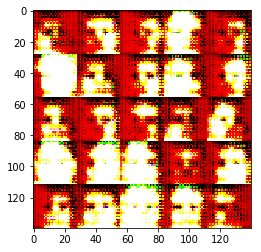

Epoch 1/1...2050 Discriminator Loss: 0.3366... Generator Loss: 5.7312
Epoch 1/1...2100 Discriminator Loss: 0.3436... Generator Loss: 5.2594
Epoch 1/1...2150 Discriminator Loss: 0.3432... Generator Loss: 7.1854
Epoch 1/1...2200 Discriminator Loss: 0.3453... Generator Loss: 5.3505
Epoch 1/1...2250 Discriminator Loss: 0.3582... Generator Loss: 5.1519
Epoch 1/1...2300 Discriminator Loss: 0.3887... Generator Loss: 4.2595
Epoch 1/1...2350 Discriminator Loss: 0.3706... Generator Loss: 5.0154
Epoch 1/1...2400 Discriminator Loss: 0.3513... Generator Loss: 4.6868
Epoch 1/1...2450 Discriminator Loss: 0.3593... Generator Loss: 5.3453
Epoch 1/1...2500 Discriminator Loss: 0.4237... Generator Loss: 3.4904


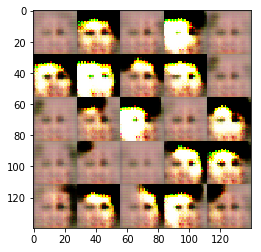

Epoch 1/1...2550 Discriminator Loss: 0.5946... Generator Loss: 2.7573
Epoch 1/1...2600 Discriminator Loss: 0.9424... Generator Loss: 1.7633
Epoch 1/1...2650 Discriminator Loss: 0.3620... Generator Loss: 5.3019
Epoch 1/1...2700 Discriminator Loss: 0.4323... Generator Loss: 3.8680
Epoch 1/1...2750 Discriminator Loss: 0.3829... Generator Loss: 3.5674
Epoch 1/1...2800 Discriminator Loss: 0.4315... Generator Loss: 3.4030
Epoch 1/1...2850 Discriminator Loss: 0.4310... Generator Loss: 2.7696
Epoch 1/1...2900 Discriminator Loss: 0.4150... Generator Loss: 2.9481
Epoch 1/1...2950 Discriminator Loss: 0.4235... Generator Loss: 3.3223
Epoch 1/1...3000 Discriminator Loss: 0.3748... Generator Loss: 4.5821


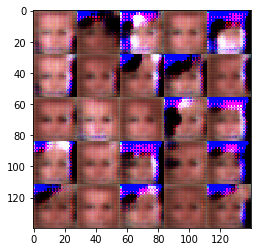

Epoch 1/1...3050 Discriminator Loss: 0.6474... Generator Loss: 7.6604
Epoch 1/1...3100 Discriminator Loss: 0.6347... Generator Loss: 1.9491
Epoch 1/1...3150 Discriminator Loss: 0.3998... Generator Loss: 3.8797
Epoch 1/1...3200 Discriminator Loss: 0.5129... Generator Loss: 2.9368
Epoch 1/1...3250 Discriminator Loss: 0.5259... Generator Loss: 3.7546
Epoch 1/1...3300 Discriminator Loss: 0.4693... Generator Loss: 3.1822
Epoch 1/1...3350 Discriminator Loss: 0.5691... Generator Loss: 2.2854
Epoch 1/1...3400 Discriminator Loss: 0.5345... Generator Loss: 3.0104
Epoch 1/1...3450 Discriminator Loss: 0.5478... Generator Loss: 2.3354
Epoch 1/1...3500 Discriminator Loss: 0.4361... Generator Loss: 4.0915


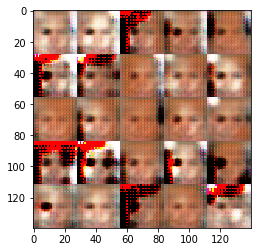

Epoch 1/1...3550 Discriminator Loss: 0.4248... Generator Loss: 2.8264
Epoch 1/1...3600 Discriminator Loss: 0.7033... Generator Loss: 1.7299
Epoch 1/1...3650 Discriminator Loss: 0.4471... Generator Loss: 3.2269
Epoch 1/1...3700 Discriminator Loss: 0.3878... Generator Loss: 3.8170
Epoch 1/1...3750 Discriminator Loss: 0.5408... Generator Loss: 3.1519
Epoch 1/1...3800 Discriminator Loss: 0.4574... Generator Loss: 4.0493
Epoch 1/1...3850 Discriminator Loss: 0.6679... Generator Loss: 1.8335
Epoch 1/1...3900 Discriminator Loss: 0.7216... Generator Loss: 1.9743
Epoch 1/1...3950 Discriminator Loss: 0.4912... Generator Loss: 4.8332
Epoch 1/1...4000 Discriminator Loss: 0.4338... Generator Loss: 2.8625


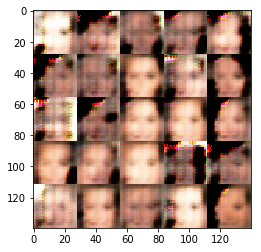

Epoch 1/1...4050 Discriminator Loss: 0.5682... Generator Loss: 2.2632
Epoch 1/1...4100 Discriminator Loss: 0.5187... Generator Loss: 3.0163
Epoch 1/1...4150 Discriminator Loss: 0.4531... Generator Loss: 3.8301
Epoch 1/1...4200 Discriminator Loss: 0.6652... Generator Loss: 4.0981
Epoch 1/1...4250 Discriminator Loss: 0.4935... Generator Loss: 3.3161
Epoch 1/1...4300 Discriminator Loss: 0.4600... Generator Loss: 2.6300
Epoch 1/1...4350 Discriminator Loss: 0.5926... Generator Loss: 2.4099
Epoch 1/1...4400 Discriminator Loss: 0.5627... Generator Loss: 3.3887
Epoch 1/1...4450 Discriminator Loss: 0.4863... Generator Loss: 3.6346
Epoch 1/1...4500 Discriminator Loss: 0.5784... Generator Loss: 3.5596


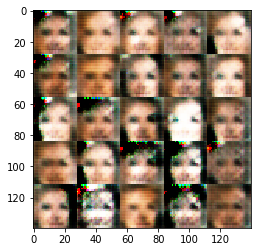

Epoch 1/1...4550 Discriminator Loss: 0.5333... Generator Loss: 2.6547
Epoch 1/1...4600 Discriminator Loss: 0.5048... Generator Loss: 3.8979
Epoch 1/1...4650 Discriminator Loss: 0.5031... Generator Loss: 5.2573
Epoch 1/1...4700 Discriminator Loss: 0.5104... Generator Loss: 3.6202
Epoch 1/1...4750 Discriminator Loss: 0.5559... Generator Loss: 2.6809
Epoch 1/1...4800 Discriminator Loss: 0.3653... Generator Loss: 5.9838
Epoch 1/1...4850 Discriminator Loss: 0.4783... Generator Loss: 2.8157
Epoch 1/1...4900 Discriminator Loss: 0.5023... Generator Loss: 2.8162
Epoch 1/1...4950 Discriminator Loss: 0.5175... Generator Loss: 2.0819
Epoch 1/1...5000 Discriminator Loss: 0.6546... Generator Loss: 1.9253


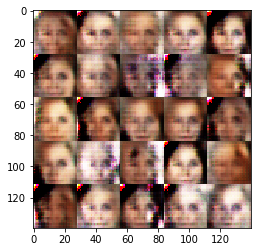

Epoch 1/1...5050 Discriminator Loss: 0.4053... Generator Loss: 3.2736
Epoch 1/1...5100 Discriminator Loss: 0.5186... Generator Loss: 2.5331
Epoch 1/1...5150 Discriminator Loss: 0.4367... Generator Loss: 5.0982
Epoch 1/1...5200 Discriminator Loss: 0.5282... Generator Loss: 3.1812
Epoch 1/1...5250 Discriminator Loss: 0.5472... Generator Loss: 2.8683
Epoch 1/1...5300 Discriminator Loss: 0.4728... Generator Loss: 4.2633
Epoch 1/1...5350 Discriminator Loss: 0.4874... Generator Loss: 4.2185
Epoch 1/1...5400 Discriminator Loss: 0.4623... Generator Loss: 3.3840
Epoch 1/1...5450 Discriminator Loss: 0.4679... Generator Loss: 3.5260
Epoch 1/1...5500 Discriminator Loss: 0.5578... Generator Loss: 2.0121


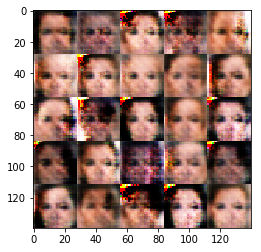

Epoch 1/1...5550 Discriminator Loss: 0.4785... Generator Loss: 3.6746
Epoch 1/1...5600 Discriminator Loss: 0.7652... Generator Loss: 2.1729
Epoch 1/1...5650 Discriminator Loss: 0.4594... Generator Loss: 3.2174
Epoch 1/1...5700 Discriminator Loss: 0.5586... Generator Loss: 2.0737
Epoch 1/1...5750 Discriminator Loss: 0.6355... Generator Loss: 2.2656
Epoch 1/1...5800 Discriminator Loss: 0.4698... Generator Loss: 3.3363
Epoch 1/1...5850 Discriminator Loss: 0.4524... Generator Loss: 3.4926
Epoch 1/1...5900 Discriminator Loss: 0.6274... Generator Loss: 3.3918
Epoch 1/1...5950 Discriminator Loss: 0.5229... Generator Loss: 2.8028
Epoch 1/1...6000 Discriminator Loss: 0.4068... Generator Loss: 3.5304


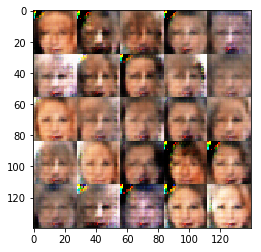

Epoch 1/1...6050 Discriminator Loss: 0.4578... Generator Loss: 3.7823
Epoch 1/1...6100 Discriminator Loss: 0.4986... Generator Loss: 2.9329
Epoch 1/1...6150 Discriminator Loss: 0.5033... Generator Loss: 5.3628
Epoch 1/1...6200 Discriminator Loss: 0.5654... Generator Loss: 2.9592
Epoch 1/1...6250 Discriminator Loss: 0.4505... Generator Loss: 4.0771
Epoch 1/1...6300 Discriminator Loss: 0.4934... Generator Loss: 4.9366
Epoch 1/1...6350 Discriminator Loss: 0.5581... Generator Loss: 3.0075
Epoch 1/1...6400 Discriminator Loss: 0.6526... Generator Loss: 4.7826
Epoch 1/1...6450 Discriminator Loss: 0.7259... Generator Loss: 1.5471
Epoch 1/1...6500 Discriminator Loss: 0.5912... Generator Loss: 3.0288


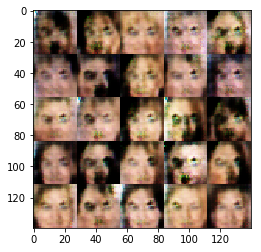

Epoch 1/1...6550 Discriminator Loss: 0.6871... Generator Loss: 1.7770
Epoch 1/1...6600 Discriminator Loss: 0.6838... Generator Loss: 2.5512
Epoch 1/1...6650 Discriminator Loss: 0.4830... Generator Loss: 3.2837
Epoch 1/1...6700 Discriminator Loss: 0.4901... Generator Loss: 2.8961
Epoch 1/1...6750 Discriminator Loss: 0.5423... Generator Loss: 2.6232
Epoch 1/1...6800 Discriminator Loss: 0.6741... Generator Loss: 2.5604
Epoch 1/1...6850 Discriminator Loss: 0.6902... Generator Loss: 1.7425
Epoch 1/1...6900 Discriminator Loss: 0.5150... Generator Loss: 2.6905
Epoch 1/1...6950 Discriminator Loss: 0.4428... Generator Loss: 3.3885
Epoch 1/1...7000 Discriminator Loss: 0.5342... Generator Loss: 2.1626


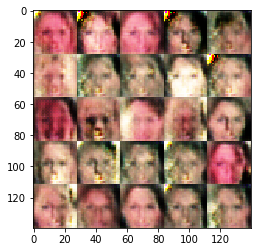

Epoch 1/1...7050 Discriminator Loss: 0.5438... Generator Loss: 2.3982
Epoch 1/1...7100 Discriminator Loss: 0.6049... Generator Loss: 2.4058
Epoch 1/1...7150 Discriminator Loss: 0.4374... Generator Loss: 3.8758
Epoch 1/1...7200 Discriminator Loss: 0.4049... Generator Loss: 3.8260
Epoch 1/1...7250 Discriminator Loss: 0.5023... Generator Loss: 2.3896
Epoch 1/1...7300 Discriminator Loss: 0.5179... Generator Loss: 3.0035
Epoch 1/1...7350 Discriminator Loss: 0.5953... Generator Loss: 2.3158
Epoch 1/1...7400 Discriminator Loss: 0.5041... Generator Loss: 4.5348
Epoch 1/1...7450 Discriminator Loss: 0.5212... Generator Loss: 2.6411
Epoch 1/1...7500 Discriminator Loss: 0.5728... Generator Loss: 2.1283


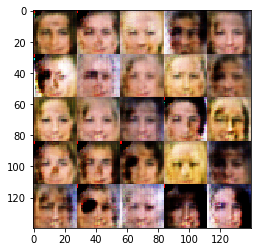

Epoch 1/1...7550 Discriminator Loss: 0.5413... Generator Loss: 2.7650
Epoch 1/1...7600 Discriminator Loss: 0.5253... Generator Loss: 2.5462
Epoch 1/1...7650 Discriminator Loss: 0.4210... Generator Loss: 3.9012
Epoch 1/1...7700 Discriminator Loss: 0.6879... Generator Loss: 1.6195
Epoch 1/1...7750 Discriminator Loss: 0.6277... Generator Loss: 3.1812
Epoch 1/1...7800 Discriminator Loss: 0.5261... Generator Loss: 3.3628
Epoch 1/1...7850 Discriminator Loss: 0.4783... Generator Loss: 2.9356
Epoch 1/1...7900 Discriminator Loss: 0.4893... Generator Loss: 2.7962
Epoch 1/1...7950 Discriminator Loss: 0.4761... Generator Loss: 3.2606
Epoch 1/1...8000 Discriminator Loss: 0.5877... Generator Loss: 2.6046


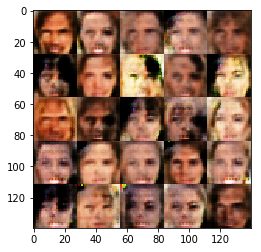

Epoch 1/1...8050 Discriminator Loss: 0.6129... Generator Loss: 4.5156
Epoch 1/1...8100 Discriminator Loss: 0.5895... Generator Loss: 2.3044
Epoch 1/1...8150 Discriminator Loss: 0.6056... Generator Loss: 2.7330
Epoch 1/1...8200 Discriminator Loss: 0.8587... Generator Loss: 1.4006
Epoch 1/1...8250 Discriminator Loss: 0.5289... Generator Loss: 2.7386
Epoch 1/1...8300 Discriminator Loss: 0.4293... Generator Loss: 3.3150
Epoch 1/1...8350 Discriminator Loss: 0.4065... Generator Loss: 3.8459
Epoch 1/1...8400 Discriminator Loss: 0.7814... Generator Loss: 1.9874
Epoch 1/1...8450 Discriminator Loss: 0.5272... Generator Loss: 2.5942
Epoch 1/1...8500 Discriminator Loss: 0.7712... Generator Loss: 1.8681


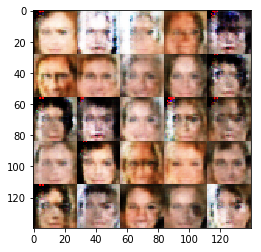

Epoch 1/1...8550 Discriminator Loss: 0.4423... Generator Loss: 3.4497
Epoch 1/1...8600 Discriminator Loss: 0.4730... Generator Loss: 3.2917
Epoch 1/1...8650 Discriminator Loss: 0.4541... Generator Loss: 2.9330
Epoch 1/1...8700 Discriminator Loss: 0.5836... Generator Loss: 1.8534
Epoch 1/1...8750 Discriminator Loss: 0.7220... Generator Loss: 2.1481
Epoch 1/1...8800 Discriminator Loss: 0.6041... Generator Loss: 2.5092
Epoch 1/1...8850 Discriminator Loss: 0.4980... Generator Loss: 2.8709
Epoch 1/1...8900 Discriminator Loss: 0.5655... Generator Loss: 2.9124
Epoch 1/1...8950 Discriminator Loss: 0.6549... Generator Loss: 1.7849
Epoch 1/1...9000 Discriminator Loss: 0.4840... Generator Loss: 2.3288


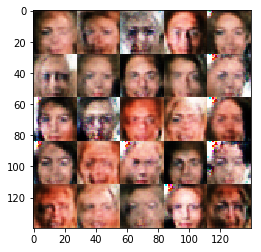

Epoch 1/1...9050 Discriminator Loss: 0.5086... Generator Loss: 3.3798
Epoch 1/1...9100 Discriminator Loss: 0.5687... Generator Loss: 1.9968
Epoch 1/1...9150 Discriminator Loss: 0.4043... Generator Loss: 4.2792
Epoch 1/1...9200 Discriminator Loss: 0.4256... Generator Loss: 4.2975
Epoch 1/1...9250 Discriminator Loss: 0.4319... Generator Loss: 3.3829
Epoch 1/1...9300 Discriminator Loss: 0.4539... Generator Loss: 3.8426
Epoch 1/1...9350 Discriminator Loss: 0.4148... Generator Loss: 4.3979
Epoch 1/1...9400 Discriminator Loss: 0.4054... Generator Loss: 3.3098
Epoch 1/1...9450 Discriminator Loss: 0.4346... Generator Loss: 3.2432
Epoch 1/1...9500 Discriminator Loss: 0.4391... Generator Loss: 4.3224


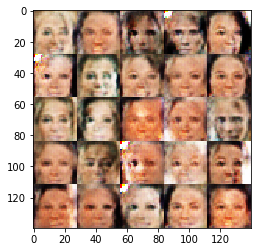

Epoch 1/1...9550 Discriminator Loss: 0.4480... Generator Loss: 3.7696
Epoch 1/1...9600 Discriminator Loss: 0.4653... Generator Loss: 5.7744
Epoch 1/1...9650 Discriminator Loss: 0.6916... Generator Loss: 1.5309
Epoch 1/1...9700 Discriminator Loss: 0.4527... Generator Loss: 3.0177
Epoch 1/1...9750 Discriminator Loss: 0.6503... Generator Loss: 1.6252
Epoch 1/1...9800 Discriminator Loss: 0.6297... Generator Loss: 2.2617
Epoch 1/1...9850 Discriminator Loss: 0.6629... Generator Loss: 2.1768
Epoch 1/1...9900 Discriminator Loss: 0.6397... Generator Loss: 2.0394
Epoch 1/1...9950 Discriminator Loss: 0.6363... Generator Loss: 2.3149
Epoch 1/1...10000 Discriminator Loss: 0.6198... Generator Loss: 1.9231


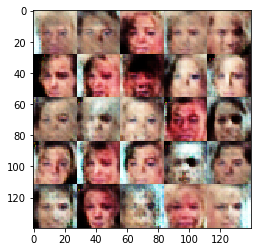

Epoch 1/1...10050 Discriminator Loss: 0.7429... Generator Loss: 2.0354
Epoch 1/1...10100 Discriminator Loss: 0.6976... Generator Loss: 3.2106
Epoch 1/1...10150 Discriminator Loss: 0.8267... Generator Loss: 2.0780
Epoch 1/1...10200 Discriminator Loss: 0.5638... Generator Loss: 3.8861
Epoch 1/1...10250 Discriminator Loss: 0.5599... Generator Loss: 2.6168
Epoch 1/1...10300 Discriminator Loss: 0.4905... Generator Loss: 3.3542
Epoch 1/1...10350 Discriminator Loss: 0.5758... Generator Loss: 1.9456
Epoch 1/1...10400 Discriminator Loss: 0.6922... Generator Loss: 3.3031
Epoch 1/1...10450 Discriminator Loss: 0.4813... Generator Loss: 3.3348
Epoch 1/1...10500 Discriminator Loss: 0.5612... Generator Loss: 2.4133


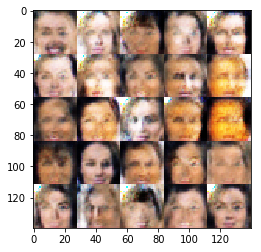

Epoch 1/1...10550 Discriminator Loss: 0.4386... Generator Loss: 3.1266
Epoch 1/1...10600 Discriminator Loss: 0.4195... Generator Loss: 3.2179
Epoch 1/1...10650 Discriminator Loss: 0.5785... Generator Loss: 2.5224
Epoch 1/1...10700 Discriminator Loss: 0.8064... Generator Loss: 2.8331
Epoch 1/1...10750 Discriminator Loss: 0.8001... Generator Loss: 1.6521
Epoch 1/1...10800 Discriminator Loss: 0.4689... Generator Loss: 3.0210
Epoch 1/1...10850 Discriminator Loss: 0.4731... Generator Loss: 2.9880
Epoch 1/1...10900 Discriminator Loss: 0.5761... Generator Loss: 2.4642
Epoch 1/1...10950 Discriminator Loss: 0.4992... Generator Loss: 3.4346
Epoch 1/1...11000 Discriminator Loss: 0.7287... Generator Loss: 1.8819


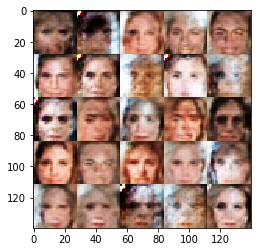

Epoch 1/1...11050 Discriminator Loss: 0.4094... Generator Loss: 4.6585
Epoch 1/1...11100 Discriminator Loss: 0.4694... Generator Loss: 2.7592
Epoch 1/1...11150 Discriminator Loss: 0.4692... Generator Loss: 4.1859
Epoch 1/1...11200 Discriminator Loss: 0.4515... Generator Loss: 3.1457
Epoch 1/1...11250 Discriminator Loss: 0.5043... Generator Loss: 2.7453
Epoch 1/1...11300 Discriminator Loss: 0.4715... Generator Loss: 2.8459
Epoch 1/1...11350 Discriminator Loss: 0.7986... Generator Loss: 3.2594
Epoch 1/1...11400 Discriminator Loss: 0.9561... Generator Loss: 1.2222
Epoch 1/1...11450 Discriminator Loss: 0.5415... Generator Loss: 3.3449
Epoch 1/1...11500 Discriminator Loss: 0.5494... Generator Loss: 3.8650


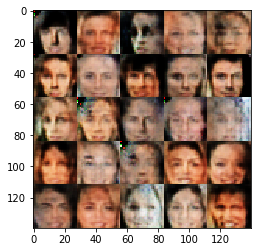

Epoch 1/1...11550 Discriminator Loss: 0.6556... Generator Loss: 1.8916
Epoch 1/1...11600 Discriminator Loss: 0.5129... Generator Loss: 2.7357
Epoch 1/1...11650 Discriminator Loss: 1.0475... Generator Loss: 1.1166
Epoch 1/1...11700 Discriminator Loss: 0.5055... Generator Loss: 2.5944
Epoch 1/1...11750 Discriminator Loss: 0.5431... Generator Loss: 2.1175
Epoch 1/1...11800 Discriminator Loss: 0.6676... Generator Loss: 2.4490
Epoch 1/1...11850 Discriminator Loss: 0.6016... Generator Loss: 2.6393
Epoch 1/1...11900 Discriminator Loss: 0.5976... Generator Loss: 1.9347
Epoch 1/1...11950 Discriminator Loss: 0.5514... Generator Loss: 2.3347
Epoch 1/1...12000 Discriminator Loss: 0.8774... Generator Loss: 1.2748


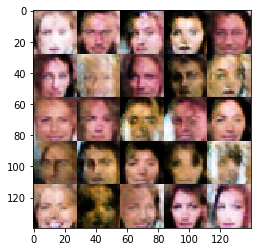

Epoch 1/1...12050 Discriminator Loss: 0.8189... Generator Loss: 2.4710
Epoch 1/1...12100 Discriminator Loss: 0.5944... Generator Loss: 2.1019
Epoch 1/1...12150 Discriminator Loss: 0.6708... Generator Loss: 1.8513
Epoch 1/1...12200 Discriminator Loss: 0.6437... Generator Loss: 1.7611
Epoch 1/1...12250 Discriminator Loss: 0.6741... Generator Loss: 2.2586
Epoch 1/1...12300 Discriminator Loss: 0.6324... Generator Loss: 2.6000
Epoch 1/1...12350 Discriminator Loss: 0.6855... Generator Loss: 3.6266
Epoch 1/1...12400 Discriminator Loss: 0.7557... Generator Loss: 2.0536
Epoch 1/1...12450 Discriminator Loss: 0.5581... Generator Loss: 3.6363
Epoch 1/1...12500 Discriminator Loss: 0.4515... Generator Loss: 3.2338


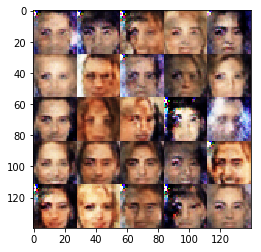

Epoch 1/1...12550 Discriminator Loss: 0.6433... Generator Loss: 1.8729
Epoch 1/1...12600 Discriminator Loss: 0.5533... Generator Loss: 2.7780
Epoch 1/1...12650 Discriminator Loss: 0.8688... Generator Loss: 1.3661
The residual time nearly to be:  0  minutes.


In [14]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。